# Predicting Employee Attrition Using Naive Bayes Classification

A Bayesian approach to identifying employees at risk of leaving, enabling proactive retention strategies.

**Author:** Noah de la Calzada
**Dataset:** [Employee Future Prediction](https://www.kaggle.com/datasets/tejashvi14/employee-future-prediction) (Kaggle)

# Overview

## Problem Domain

Employee attrition is fundamentally a prediction problem: given what we know about an employee today, can we estimate the probability they will leave? The cost of getting this wrong is asymmetric — failing to identify an at-risk employee means losing institutional knowledge, incurring recruitment costs, and disrupting team productivity. Flagging someone who stays is far less costly.

Naive Bayes classifiers approach this problem through Bayes' theorem, computing posterior probabilities directly from the data. Unlike logistic regression, which models the log-odds of attrition as a linear function of features, Naive Bayes models the joint distribution of features within each class and inverts it via Bayes' rule. The "naive" conditional independence assumption rarely holds in practice, but the resulting classifier is often surprisingly competitive — particularly on smaller datasets where more complex models risk overfitting.

This analysis uses the same employee dataset from a prior logistic regression study, which makes it possible to compare how two fundamentally different modeling assumptions handle the same prediction task. Naive Bayes also offers practical advantages: it trains in a single pass, produces calibrated probability estimates, and can be updated incrementally as new data arrives.

## Objective

Build a Naive Bayes classifier that predicts whether an employee will leave, then evaluate it on the dimensions that matter for HR decision-making:

1. **Modeling approach comparison** — How does a generative probabilistic model (Naive Bayes) compare to the discriminative logistic regression baseline?
2. **Feature analysis** — Which employee attributes carry the most information about attrition risk, according to the Bayesian likelihood estimates?
3. **Practical utility** — Are the predicted probabilities reliable enough to prioritize retention interventions?
4. **Variant selection** — GaussianNB, ComplementNB, and BernoulliNB each make different distributional assumptions. Which variant best fits this mixed-type dataset with moderate class imbalance?

# Analysis

## Exploratory Analysis

Before fitting any model, the data needs to be examined for two things that directly affect Naive Bayes performance: (1) whether continuous features approximate the Gaussian distributions that GaussianNB assumes, and (2) how severe the class imbalance is, since Naive Bayes learns class priors directly from training frequencies.

A prior exploratory analysis on this dataset identified several strong attrition predictors — gender, city, payment tier, and education level. The focus here is on distributional properties rather than repeating that earlier exploration.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, ComplementNB, BernoulliNB
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 10

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [2]:
# load the data
df = pd.read_csv('Employee.csv')

print(f"Dataset shape: {df.shape}")
print(f"Rows: {df.shape[0]:,}, Columns: {df.shape[1]}")

df.head(10)

Dataset shape: (4653, 9)
Rows: 4,653, Columns: 9


,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1
5,Bachelors,2016,Bangalore,3,22,Male,No,0,0
6,Bachelors,2015,New Delhi,3,38,Male,No,0,0
7,Bachelors,2016,Bangalore,3,34,Female,No,2,1
8,Bachelors,2016,Pune,3,23,Male,No,1,0
9,Masters,2017,New Delhi,2,37,Male,No,2,0


In [3]:
# check data types and basic info
df.info()

print("\n")
df.describe()

<class 'pandas.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   Education                  4653 non-null   str  
 1   JoiningYear                4653 non-null   int64
 2   City                       4653 non-null   str  
 3   PaymentTier                4653 non-null   int64
 4   Age                        4653 non-null   int64
 5   Gender                     4653 non-null   str  
 6   EverBenched                4653 non-null   str  
 7   ExperienceInCurrentDomain  4653 non-null   int64
 8   LeaveOrNot                 4653 non-null   int64
dtypes: int64(5), str(4)
memory usage: 327.3 KB




,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


In [4]:
# check for missing values
print("Missing values per column:")
print(df.isnull().sum())
print(f"\nTotal missing: {df.isnull().sum().sum()}")
# good, no missing data to deal with

Missing values per column:
Education                    0
JoiningYear                  0
City                         0
PaymentTier                  0
Age                          0
Gender                       0
EverBenched                  0
ExperienceInCurrentDomain    0
LeaveOrNot                   0
dtype: int64

Total missing: 0


### Variables

**Target:** `LeaveOrNot` — 1 if the employee left, 0 if they stayed

**Features:**
- `Education` — Bachelors, Masters, or PHD (categorical)
- `JoiningYear` — year the employee joined the company (numerical)
- `City` — Bangalore, Pune, or New Delhi (categorical)
- `PaymentTier` — compensation level: 1, 2, or 3 (ordinal)
- `Age` — employee age (numerical)
- `Gender` — Male or Female (categorical)
- `EverBenched` — whether the employee was ever unassigned between projects (categorical)
- `ExperienceInCurrentDomain` — years of relevant experience (numerical)

For GaussianNB, the continuous features (Age, JoiningYear, ExperienceInCurrentDomain) should ideally follow approximately normal distributions within each class. The Q-Q plots above provide a visual check of this assumption.

In [5]:
# target variable - how many left vs stayed?
print("Target variable distribution:")
print(df['LeaveOrNot'].value_counts().sort_index())
print(f"\nLeave rate: {df['LeaveOrNot'].mean()*100:.1f}%")
print(f"Class balance ratio (Stay/Leave): {(df['LeaveOrNot']==0).sum() / (df['LeaveOrNot']==1).sum():.2f}")
# moderately imbalanced - about 2:1 ratio

Target variable distribution:
LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64

Leave rate: 34.4%
Class balance ratio (Stay/Leave): 1.91


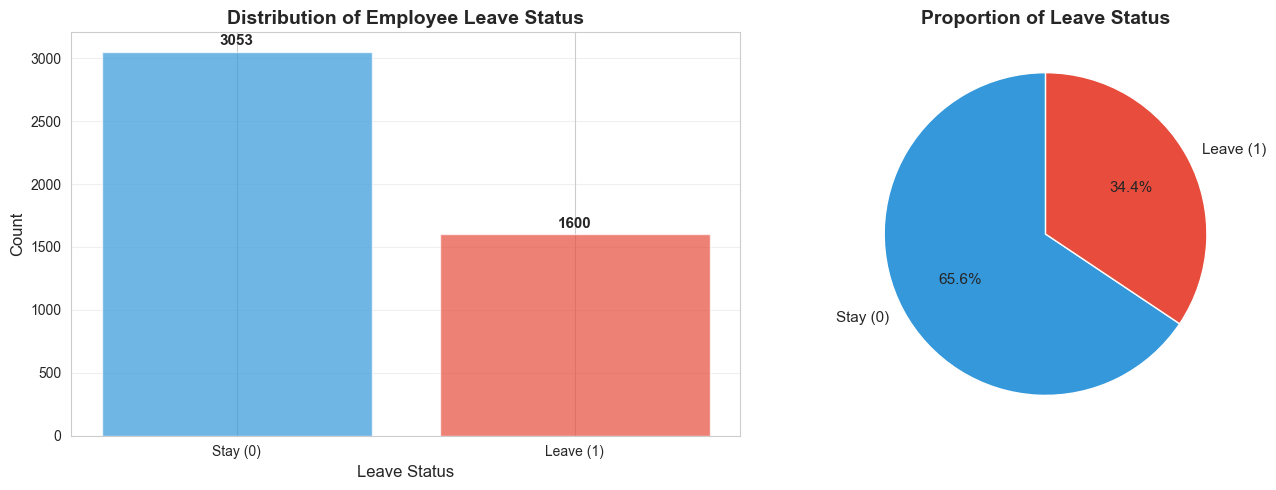

Class distribution: 3053 employees stayed (65.6%) and 1600 employees left (34.4%)


In [6]:
# Visualize the target variable distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
target_counts = df['LeaveOrNot'].value_counts().sort_index()
axes[0].bar(['Stay (0)', 'Leave (1)'], target_counts.values, color=['#3498db', '#e74c3c'], alpha=0.7)
axes[0].set_xlabel('Leave Status', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Employee Leave Status', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(target_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontsize=11, fontweight='bold')

# Pie chart for proportion
colors = ['#3498db', '#e74c3c']
axes[1].pie(target_counts.values, labels=['Stay (0)', 'Leave (1)'], autopct='%1.1f%%', 
            colors=colors, startangle=90, textprops={'fontsize': 11})
axes[1].set_title('Proportion of Leave Status', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Class distribution: {target_counts[0]} employees stayed ({target_counts[0]/len(df)*100:.1f}%) "
      f"and {target_counts[1]} employees left ({target_counts[1]/len(df)*100:.1f}%)")

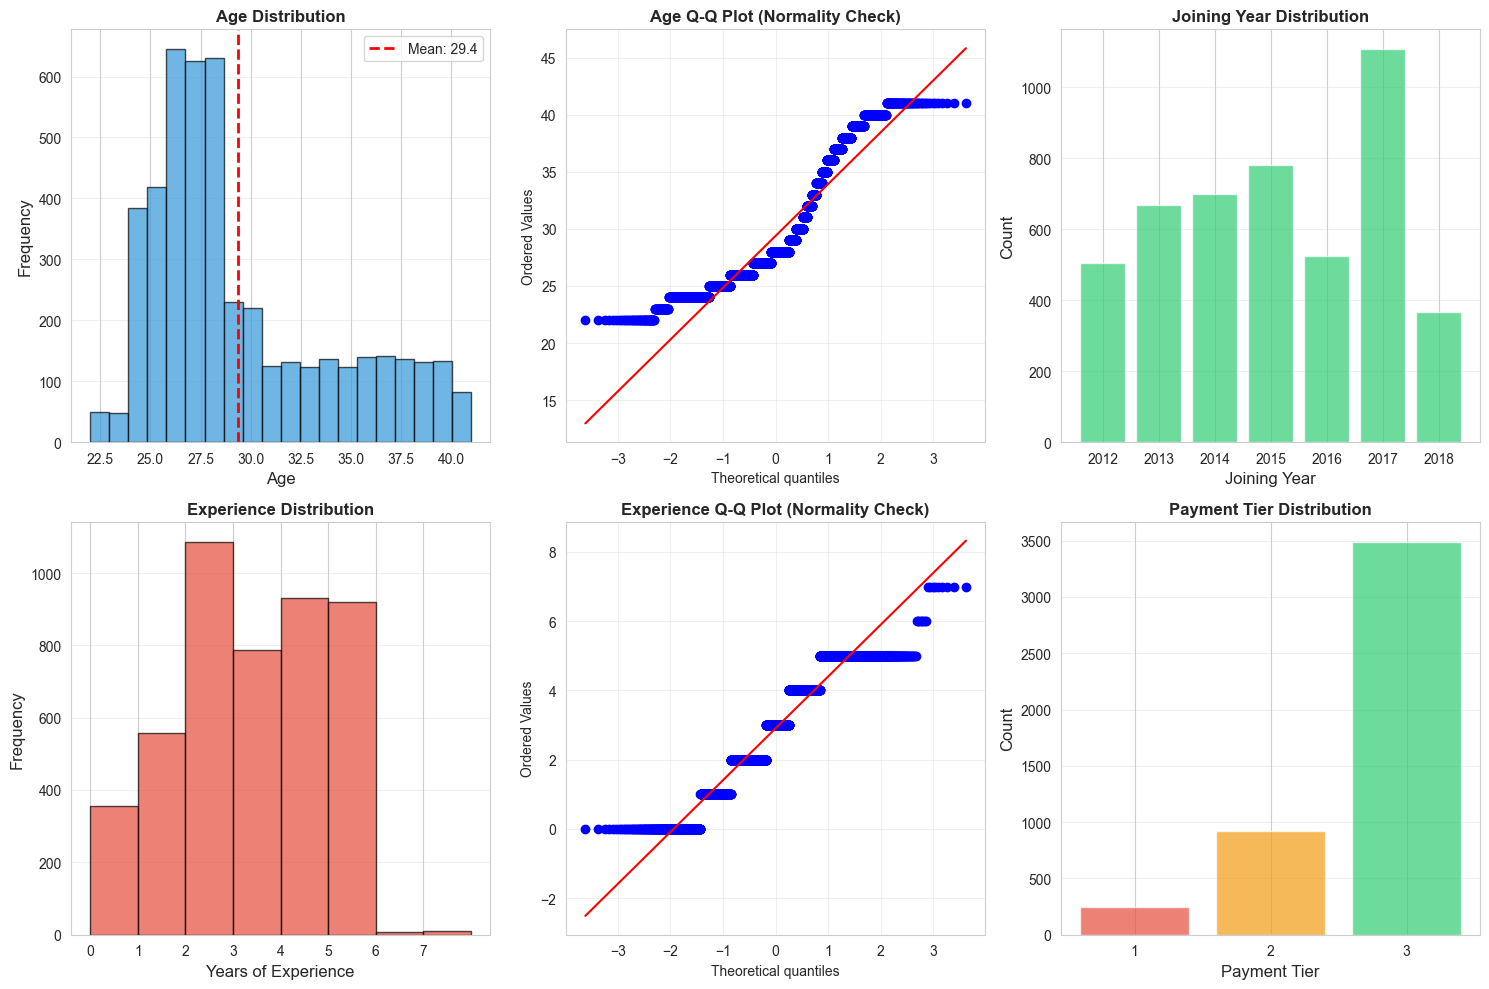

Distribution checks:
Age - Mean: 29.39, Std: 4.83
Experience - Mean: 2.91, Std: 1.56

Note: JoiningYear is discrete and not really continuous, but I'll include it anyway.
The continuous features (Age, Experience) are roughly normal-ish, which is good for GaussianNB.


In [7]:
# Check distribution of continuous features - GaussianNB assumes normality
# Let's look at Age, JoiningYear, and ExperienceInCurrentDomain
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Age distribution
axes[0, 0].hist(df['Age'], bins=20, color='#3498db', alpha=0.7, edgecolor='black')
axes[0, 0].set_xlabel('Age', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].set_title('Age Distribution', fontsize=12, fontweight='bold')
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].axvline(df['Age'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["Age"].mean():.1f}')
axes[0, 0].legend()

# Age Q-Q plot (rough check for normality)
from scipy import stats
stats.probplot(df['Age'], dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Age Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[0, 1].grid(alpha=0.3)

# JoiningYear distribution
year_counts = df['JoiningYear'].value_counts().sort_index()
axes[0, 2].bar(year_counts.index.astype(str), year_counts.values, color='#2ecc71', alpha=0.7)
axes[0, 2].set_xlabel('Joining Year', fontsize=12)
axes[0, 2].set_ylabel('Count', fontsize=12)
axes[0, 2].set_title('Joining Year Distribution', fontsize=12, fontweight='bold')
axes[0, 2].grid(axis='y', alpha=0.3)

# Experience distribution
axes[1, 0].hist(df['ExperienceInCurrentDomain'], bins=range(0, df['ExperienceInCurrentDomain'].max()+2), 
             color='#e74c3c', alpha=0.7, edgecolor='black')
axes[1, 0].set_xlabel('Years of Experience', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].set_title('Experience Distribution', fontsize=12, fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)
axes[1, 0].set_xticks(range(0, df['ExperienceInCurrentDomain'].max()+1))

# Experience Q-Q plot
stats.probplot(df['ExperienceInCurrentDomain'], dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Experience Q-Q Plot (Normality Check)', fontsize=12, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

# PaymentTier distribution
payment_counts = df['PaymentTier'].value_counts().sort_index()
axes[1, 2].bar(payment_counts.index.astype(str), payment_counts.values, 
              color=['#e74c3c', '#f39c12', '#2ecc71'], alpha=0.7)
axes[1, 2].set_xlabel('Payment Tier', fontsize=12)
axes[1, 2].set_ylabel('Count', fontsize=12)
axes[1, 2].set_title('Payment Tier Distribution', fontsize=12, fontweight='bold')
axes[1, 2].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/feature_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("Distribution checks:")
print(f"Age - Mean: {df['Age'].mean():.2f}, Std: {df['Age'].std():.2f}")
print(f"Experience - Mean: {df['ExperienceInCurrentDomain'].mean():.2f}, Std: {df['ExperienceInCurrentDomain'].std():.2f}")
print("\nNote: JoiningYear is discrete and not really continuous, but I'll include it anyway.")
print("The continuous features (Age, Experience) are roughly normal-ish, which is good for GaussianNB.")

In [8]:
# Quick look at categorical feature distributions
print("Categorical Feature Distributions:")
print("=" * 60)
print("\nEducation:")
print(df['Education'].value_counts())
print("\nCity:")
print(df['City'].value_counts())
print("\nGender:")
print(df['Gender'].value_counts())
print("\nEverBenched:")
print(df['EverBenched'].value_counts())

Categorical Feature Distributions:

Education:
Education
Bachelors    3601
Masters       873
PHD           179
Name: count, dtype: int64

City:
City
Bangalore    2228
Pune         1268
New Delhi    1157
Name: count, dtype: int64

Gender:
Gender
Male      2778
Female    1875
Name: count, dtype: int64

EverBenched:
EverBenched
No     4175
Yes     478
Name: count, dtype: int64


### Key Findings from EDA

The exploratory analysis confirms several properties relevant to model selection:

- **No missing values** — the dataset is clean and requires no imputation
- **Class imbalance**: 34.4% left vs 65.6% stayed — a ~2:1 ratio that will bias default classifiers toward the majority class and suppress recall on the minority (Leave) class
- **Distributional fit**: Age is approximately normal; ExperienceInCurrentDomain and JoiningYear are more discrete/skewed, which means GaussianNB's normality assumption is only partially satisfied
- **Known predictors** (from prior analysis): Gender (47% female attrition vs 26% male), City (Pune at ~50%), PaymentTier (Tier 2 at ~60%), and Education (Masters holders) show the strongest associations with attrition

The class imbalance is the most consequential finding for modeling — it motivates testing equal priors, threshold tuning, and imbalance-aware NB variants in addition to the default GaussianNB.

## Preprocessing

Naive Bayes requires all features to be numeric, and the choice of encoding affects which variant can be used. The preprocessing strategy:

1. **One-hot encode** categorical variables (Education, City, Gender, EverBenched) with `drop_first=True` to avoid multicollinearity
2. **Retain numerical features** as-is (Age, JoiningYear, ExperienceInCurrentDomain) and PaymentTier as ordinal
3. **Stratified 80/20 split** to preserve the class ratio in both train and test sets
4. **StandardScaler** fit on training data only (prevents data leakage) — GaussianNB is scale-invariant in theory, but scaling improves numerical stability and allows fair comparison if switching variants

This produces 10 features: 4 original numerical + 6 binary indicators from one-hot encoding.

In [9]:
# reload data and split into X and y
df = pd.read_csv('Employee.csv')

X = df.drop('LeaveOrNot', axis=1)
y = df['LeaveOrNot']

print("X shape:", X.shape)
print("y shape:", y.shape)
print("\nFeature types:")
print(f"Categorical: Education, City, Gender, EverBenched")
print(f"Numerical: Age, JoiningYear, ExperienceInCurrentDomain")
print(f"Ordinal: PaymentTier")

X shape: (4653, 8)
y shape: (4653,)

Feature types:
Categorical: Education, City, Gender, EverBenched
Numerical: Age, JoiningYear, ExperienceInCurrentDomain
Ordinal: PaymentTier


In [10]:
# one-hot encode categorical variables
categorical_cols = ['Education', 'City', 'Gender', 'EverBenched']
X_encoded = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

print("Shape after encoding:", X_encoded.shape)
print("Columns:", X_encoded.columns.tolist())
X_encoded.head()

Shape after encoding: (4653, 10)
Columns: ['JoiningYear', 'PaymentTier', 'Age', 'ExperienceInCurrentDomain', 'Education_Masters', 'Education_PHD', 'City_New Delhi', 'City_Pune', 'Gender_Male', 'EverBenched_Yes']


,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,Education_Masters,Education_PHD,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes
0,2017,3,34,0,False,False,False,False,True,False
1,2013,1,28,3,False,False,False,True,False,False
2,2014,3,38,2,False,False,True,False,False,False
3,2016,3,27,5,True,False,False,False,True,False
4,2017,3,24,2,True,False,False,True,True,True


In [11]:
# 80/20 train test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Train: {X_train.shape[0]}, Test: {X_test.shape[0]}")
print(f"Train leave rate: {y_train.mean()*100:.1f}%")
print(f"Test leave rate: {y_test.mean()*100:.1f}%")
# good, stratify kept the proportions similar

Train: 3722, Test: 931
Train leave rate: 34.4%
Test leave rate: 34.4%


In [12]:
# scale features - GaussianNB works better with scaled features
# fit only on train to avoid data leakage
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert back to dataframe to keep column names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Scaling complete")
print(f"Train shape: {X_train_scaled.shape}")
X_train_scaled.head(3)

Scaling complete
Train shape: (3722, 10)


,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,Education_Masters,Education_PHD,City_New Delhi,City_Pune,Gender_Male,EverBenched_Yes
4097,-1.660210,0.536275,1.787302,-1.230717,-0.481284,-0.199888,1.741408,-0.601145,-1.233564,-0.334228
1694,1.559295,0.536275,-0.697541,0.696658,-0.481284,-0.199888,-0.574248,-0.601145,0.810659,-0.334228
2659,0.486126,0.536275,-0.490470,1.339116,-0.481284,-0.199888,-0.574248,1.663492,0.810659,-0.334228


Preprocessing complete. The pipeline produced 10 features from the original 8 columns (4 numerical + 6 one-hot indicators). The stratified split preserved the 34.4% leave rate in both partitions, and scaling was fit exclusively on training data to prevent information leakage into the test set.

The next step is model fitting — starting with baseline GaussianNB, then systematically testing whether the class imbalance requires corrective measures.

## Model Fitting

I'll start with a baseline GaussianNB model, then experiment with hyperparameter tuning. The main parameter for GaussianNB is `var_smoothing`, which helps prevent zero probabilities when a feature value hasn't been seen in training.

I'll also try other Naive Bayes variants to see if they perform better:
- **GaussianNB**: For continuous features (what I'm using)
- **ComplementNB**: Designed for imbalanced datasets (might help with our 34% leave rate)
- **BernoulliNB**: For binary features (could work with one-hot encoded categoricals)

Let me start with GaussianNB and tune var_smoothing.

In [13]:
# baseline GaussianNB with default parameters
model_baseline = GaussianNB()
model_baseline.fit(X_train_scaled, y_train)

train_score = model_baseline.score(X_train_scaled, y_train)
test_score = model_baseline.score(X_test_scaled, y_test)

print(f"Baseline GaussianNB:")
print(f"  Train accuracy: {train_score*100:.2f}%")
print(f"  Test accuracy: {test_score*100:.2f}%")
# decent starting point, let's see if tuning helps

Baseline GaussianNB:
  Train accuracy: 69.61%
  Test accuracy: 71.97%


In [14]:
# hyperparameter tuning with GridSearchCV
# var_smoothing is the key parameter - it adds a small value to variance to prevent zero probabilities
# smaller values = more sensitive to training data, larger = more smoothing

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3]
}

grid_search = GridSearchCV(
    GaussianNB(),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

print("Starting grid search for var_smoothing...")
grid_search.fit(X_train_scaled, y_train)

Starting grid search for var_smoothing...
Fitting 5 folds for each of 7 candidates, totalling 35 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",GaussianNB()
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'var_smoothing': [1e-09, 1e-08, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is displayed;- >2 : the score is also displayed;- >3 : the fold and candidate paramete

In [15]:
# check best parameters
print("Best var_smoothing:", grid_search.best_params_)
print(f"Best CV score: {grid_search.best_score_*100:.2f}%")
print(f"\nAll CV results:")
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['param_var_smoothing', 'mean_test_score', 'std_test_score']].sort_values('mean_test_score', ascending=False))

Best var_smoothing: {'var_smoothing': 0.001}
Best CV score: 69.16%

All CV results:
   param_var_smoothing  mean_test_score  std_test_score
6         1.000000e-03         0.691561        0.014402
0         1.000000e-09         0.691292        0.014139
1         1.000000e-08         0.691292        0.014139
2         1.000000e-07         0.691292        0.014139
3         1.000000e-06         0.691292        0.014139
4         1.000000e-05         0.691292        0.014139
5         1.000000e-04         0.691292        0.014139


In [16]:
# train final model with best parameters
final_model = GaussianNB(var_smoothing=grid_search.best_params_['var_smoothing'])
final_model.fit(X_train_scaled, y_train)

final_train_score = final_model.score(X_train_scaled, y_train)
final_test_score = final_model.score(X_test_scaled, y_test)

print(f"Final GaussianNB (tuned):")
print(f"  Train accuracy: {final_train_score*100:.2f}%")
print(f"  Test accuracy: {final_test_score*100:.2f}%")
print(f"  Improvement over baseline: {(final_test_score - test_score)*100:.2f}%")

Final GaussianNB (tuned):
  Train accuracy: 69.61%
  Test accuracy: 72.07%
  Improvement over baseline: 0.11%


In [17]:
# --- Class Imbalance Experiments ---
# the original cell 24 just dismissed the need for other variants without testing.
# let me actually run the experiments and see what happens!
# our data has a ~2:1 class imbalance (65.6% Stay vs 34.4% Leave).
# that might hurt recall on the minority class (Leave), so let's test a few approaches.

# Experiment 1: GaussianNB with equal class priors [0.5, 0.5]
# by default GaussianNB learns priors from the data (matching the class frequencies).
# setting priors=[0.5, 0.5] tells the model to treat both classes as equally likely,
# which should boost its willingness to predict "Leave" and improve recall.

model_equal_priors = GaussianNB(
    var_smoothing=grid_search.best_params_['var_smoothing'],
    priors=[0.5, 0.5]
)
model_equal_priors.fit(X_train_scaled, y_train)

y_pred_ep = model_equal_priors.predict(X_test_scaled)
y_pred_proba_ep = model_equal_priors.predict_proba(X_test_scaled)

cm_ep = confusion_matrix(y_test, y_pred_ep)
TN_ep, FP_ep, FN_ep, TP_ep = cm_ep.ravel()

acc_ep = accuracy_score(y_test, y_pred_ep)
prec_ep = precision_score(y_test, y_pred_ep)
rec_ep = recall_score(y_test, y_pred_ep)
spec_ep = TN_ep / (TN_ep + FP_ep)
f1_ep = f1_score(y_test, y_pred_ep)
auc_ep = roc_auc_score(y_test, y_pred_proba_ep[:, 1])

print("Experiment 1: GaussianNB with Equal Priors [0.5, 0.5]")
print("=" * 60)
print(f"  Accuracy:    {acc_ep*100:.2f}%")
print(f"  Precision:   {prec_ep*100:.2f}%")
print(f"  Recall:      {rec_ep*100:.2f}%")
print(f"  Specificity: {spec_ep*100:.2f}%")
print(f"  F1 Score:    {f1_ep:.4f}")
print(f"  AUC:         {auc_ep:.4f}")

# quick comparison with the baseline
y_pred_base = final_model.predict(X_test_scaled)
rec_base = recall_score(y_test, y_pred_base)
prec_base = precision_score(y_test, y_pred_base)
print(f"\nCompared to baseline (data-learned priors):")
print(f"  Recall:    {rec_base*100:.2f}% -> {rec_ep*100:.2f}% ({(rec_ep-rec_base)*100:+.2f}%)")
print(f"  Precision: {prec_base*100:.2f}% -> {prec_ep*100:.2f}% ({(prec_ep-prec_base)*100:+.2f}%)")

Experiment 1: GaussianNB with Equal Priors [0.5, 0.5]
  Accuracy:    68.96%
  Precision:   53.79%
  Recall:      68.75%
  Specificity: 69.07%
  F1 Score:    0.6036
  AUC:         0.7249

Compared to baseline (data-learned priors):
  Recall:    58.13% -> 68.75% (+10.62%)
  Precision: 59.62% -> 53.79% (-5.83%)


Experiment 2: Classification Threshold Tuning
Threshold    Accuracy     Precision    Recall       F1          
---------------------------------------------------------------------------
0.30         67.13        51.58        71.25        0.5984      
0.35         69.39        54.32        68.75        0.6069      
0.40         70.57        56.05        66.56        0.6086      
0.45         71.32        57.64        62.50        0.5997      
0.50         72.07        59.62        58.13        0.5886      

Best threshold by F1: 0.40 (F1=0.6086, Recall=66.56%)


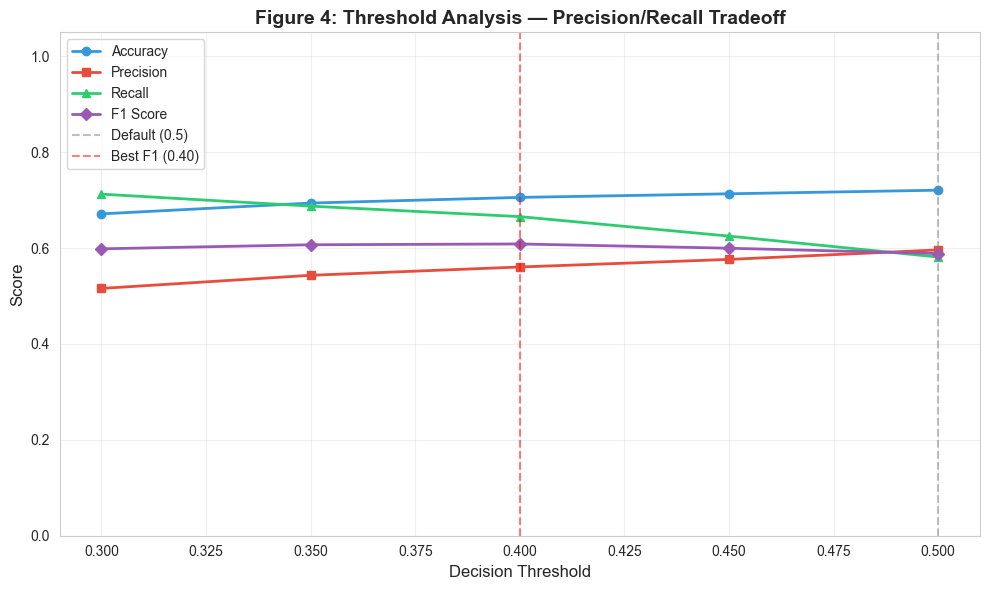

Figure 4: As the threshold decreases, recall improves (we catch more leavers)
but precision drops (more false alarms). The best F1 threshold balances both.


In [18]:
# Experiment 2: Classification threshold tuning
# the default threshold is 0.5 — predict "Leave" when P(Leave) > 0.5
# lowering it catches more leavers (better recall) at the cost of more false alarms (worse precision)
# this is a key tradeoff for HR: miss fewer at-risk employees vs. waste resources on false positives

y_proba_base = final_model.predict_proba(X_test_scaled)[:, 1]
thresholds_to_test = [0.30, 0.35, 0.40, 0.45, 0.50]

threshold_results = []
print("Experiment 2: Classification Threshold Tuning")
print("=" * 75)
print(f"{'Threshold':<12} {'Accuracy':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 75)

for t in thresholds_to_test:
    y_pred_t = (y_proba_base >= t).astype(int)
    acc_t = accuracy_score(y_test, y_pred_t)
    prec_t = precision_score(y_test, y_pred_t, zero_division=0)
    rec_t = recall_score(y_test, y_pred_t)
    f1_t = f1_score(y_test, y_pred_t)
    threshold_results.append({
        'threshold': t, 'accuracy': acc_t, 'precision': prec_t,
        'recall': rec_t, 'f1': f1_t
    })
    print(f"{t:<12.2f} {acc_t*100:<12.2f} {prec_t*100:<12.2f} {rec_t*100:<12.2f} {f1_t:<12.4f}")

best_thresh_info = max(threshold_results, key=lambda x: x['f1'])
print(f"\nBest threshold by F1: {best_thresh_info['threshold']:.2f} "
      f"(F1={best_thresh_info['f1']:.4f}, Recall={best_thresh_info['recall']*100:.2f}%)")

# visualize the precision-recall tradeoff across thresholds
fig, ax = plt.subplots(figsize=(10, 6))
thresh_vals = [r['threshold'] for r in threshold_results]
ax.plot(thresh_vals, [r['accuracy'] for r in threshold_results],
        'o-', label='Accuracy', linewidth=2, color='#3498db')
ax.plot(thresh_vals, [r['precision'] for r in threshold_results],
        's-', label='Precision', linewidth=2, color='#e74c3c')
ax.plot(thresh_vals, [r['recall'] for r in threshold_results],
        '^-', label='Recall', linewidth=2, color='#2ecc71')
ax.plot(thresh_vals, [r['f1'] for r in threshold_results],
        'D-', label='F1 Score', linewidth=2, color='#9b59b6')
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Default (0.5)')
ax.axvline(x=best_thresh_info['threshold'], color='red', linestyle='--', alpha=0.5,
           label=f'Best F1 ({best_thresh_info["threshold"]:.2f})')
ax.set_xlabel('Decision Threshold', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Figure 4: Threshold Analysis — Precision/Recall Tradeoff',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(alpha=0.3)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig('figures/threshold_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4: As the threshold decreases, recall improves (we catch more leavers)")
print("but precision drops (more false alarms). The best F1 threshold balances both.")

In [19]:
# Experiment 3: ComplementNB and BernoulliNB on non-scaled encoded data
# these variants require non-negative inputs, so I'm using X_train / X_test (unscaled)
# ComplementNB was designed for imbalanced datasets (originally for text)
# BernoulliNB is designed for binary features (fits our one-hot encoded columns)
# the unscaled data has JoiningYear (2012-2018), PaymentTier (1-3), Age (22-41),
# ExperienceInCurrentDomain (0-7), plus binary 0/1 columns — all non-negative

model_complement = ComplementNB()
model_complement.fit(X_train, y_train)
y_pred_cnb = model_complement.predict(X_test)
y_pred_proba_cnb = model_complement.predict_proba(X_test)

cm_cnb = confusion_matrix(y_test, y_pred_cnb)
TN_cnb, FP_cnb, FN_cnb, TP_cnb = cm_cnb.ravel()

acc_cnb = accuracy_score(y_test, y_pred_cnb)
prec_cnb = precision_score(y_test, y_pred_cnb)
rec_cnb = recall_score(y_test, y_pred_cnb)
spec_cnb = TN_cnb / (TN_cnb + FP_cnb)
f1_cnb = f1_score(y_test, y_pred_cnb)
auc_cnb = roc_auc_score(y_test, y_pred_proba_cnb[:, 1])

print("Experiment 3a: ComplementNB (on unscaled encoded data)")
print("=" * 60)
print(f"  Accuracy:    {acc_cnb*100:.2f}%")
print(f"  Precision:   {prec_cnb*100:.2f}%")
print(f"  Recall:      {rec_cnb*100:.2f}%")
print(f"  Specificity: {spec_cnb*100:.2f}%")
print(f"  F1 Score:    {f1_cnb:.4f}")
print(f"  AUC:         {auc_cnb:.4f}")

model_bernoulli = BernoulliNB()
model_bernoulli.fit(X_train, y_train)
y_pred_bnb = model_bernoulli.predict(X_test)
y_pred_proba_bnb = model_bernoulli.predict_proba(X_test)

cm_bnb = confusion_matrix(y_test, y_pred_bnb)
TN_bnb, FP_bnb, FN_bnb, TP_bnb = cm_bnb.ravel()

acc_bnb = accuracy_score(y_test, y_pred_bnb)
prec_bnb = precision_score(y_test, y_pred_bnb)
rec_bnb = recall_score(y_test, y_pred_bnb)
spec_bnb = TN_bnb / (TN_bnb + FP_bnb)
f1_bnb = f1_score(y_test, y_pred_bnb)
auc_bnb = roc_auc_score(y_test, y_pred_proba_bnb[:, 1])

print(f"\nExperiment 3b: BernoulliNB (on unscaled encoded data)")
print("=" * 60)
print(f"  Accuracy:    {acc_bnb*100:.2f}%")
print(f"  Precision:   {prec_bnb*100:.2f}%")
print(f"  Recall:      {rec_bnb*100:.2f}%")
print(f"  Specificity: {spec_bnb*100:.2f}%")
print(f"  F1 Score:    {f1_bnb:.4f}")
print(f"  AUC:         {auc_bnb:.4f}")

Experiment 3a: ComplementNB (on unscaled encoded data)
  Accuracy:    68.31%
  Precision:   52.96%
  Recall:      70.00%
  Specificity: 67.43%
  F1 Score:    0.6030
  AUC:         0.7316

Experiment 3b: BernoulliNB (on unscaled encoded data)
  Accuracy:    76.58%
  Precision:   72.37%
  Recall:      51.56%
  Specificity: 89.69%
  F1 Score:    0.6022
  AUC:         0.7223


Class Imbalance Experiment Results
                   Method  Accuracy  Precision  Recall     F1    AUC  Specificity
       GaussianNB (tuned)    0.7207     0.5962  0.5813 0.5886 0.7249       0.7938
GaussianNB (equal priors)    0.6896     0.5379  0.6875 0.6036 0.7249       0.6907
 GaussianNB (thresh=0.40)    0.7057     0.5605  0.6656 0.6086 0.7249       0.7267
             ComplementNB    0.6831     0.5296  0.7000 0.6030 0.7316       0.6743
              BernoulliNB    0.7658     0.7237  0.5156 0.6022 0.7223       0.8969

Best model by F1 score: GaussianNB (thresh=0.40)
  F1        = 0.6086
  Accuracy  = 70.57%
  Recall    = 66.56%
  Precision = 56.05%
  AUC       = 0.7249

Using 'GaussianNB (thresh=0.40)' for all downstream evaluation.
Note: using custom threshold = 0.4 instead of the default 0.5


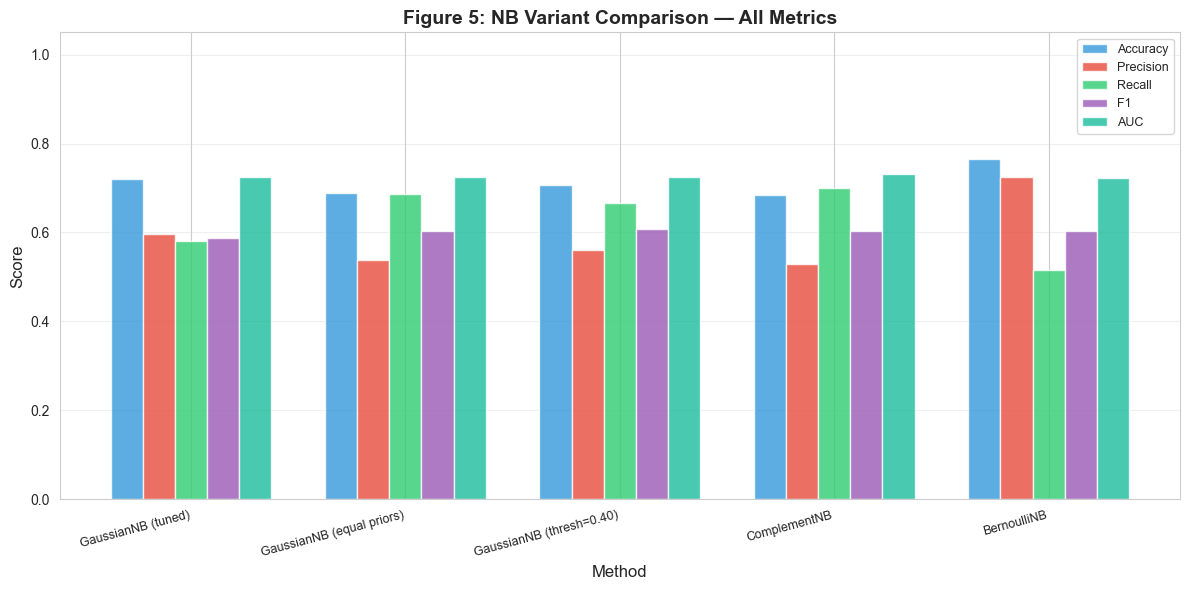

Figure 5: Side-by-side comparison of all NB variants across key metrics.
This shows the actual tradeoffs between approaches rather than guessing.


In [20]:
# Comparison table — let's see which approach actually worked best
# I'll compare all five variants side by side

# compute best-threshold predictions
best_thresh_val = best_thresh_info['threshold']
y_pred_bt = (y_proba_base >= best_thresh_val).astype(int)
cm_bt = confusion_matrix(y_test, y_pred_bt)
TN_bt, FP_bt, FN_bt, TP_bt = cm_bt.ravel()

# store all results with their model objects and test data references
all_variants = {
    'GaussianNB (tuned)': {
        'model': final_model, 'X_test_ref': X_test_scaled,
        'y_pred': final_model.predict(X_test_scaled),
        'y_proba': final_model.predict_proba(X_test_scaled)[:, 1],
        'threshold': 0.5, 'uses_scaled': True,
    },
    'GaussianNB (equal priors)': {
        'model': model_equal_priors, 'X_test_ref': X_test_scaled,
        'y_pred': y_pred_ep, 'y_proba': y_pred_proba_ep[:, 1],
        'threshold': 0.5, 'uses_scaled': True,
    },
    f'GaussianNB (thresh={best_thresh_val:.2f})': {
        'model': final_model, 'X_test_ref': X_test_scaled,
        'y_pred': y_pred_bt, 'y_proba': y_proba_base,
        'threshold': best_thresh_val, 'uses_scaled': True,
    },
    'ComplementNB': {
        'model': model_complement, 'X_test_ref': X_test,
        'y_pred': y_pred_cnb, 'y_proba': y_pred_proba_cnb[:, 1],
        'threshold': 0.5, 'uses_scaled': False,
    },
    'BernoulliNB': {
        'model': model_bernoulli, 'X_test_ref': X_test,
        'y_pred': y_pred_bnb, 'y_proba': y_pred_proba_bnb[:, 1],
        'threshold': 0.5, 'uses_scaled': False,
    },
}

comparison_rows = []
for name, data in all_variants.items():
    yp = data['y_pred']
    cm_tmp = confusion_matrix(y_test, yp)
    tn, fp, fn, tp = cm_tmp.ravel()
    comparison_rows.append({
        'Method': name,
        'Accuracy': accuracy_score(y_test, yp),
        'Precision': precision_score(y_test, yp, zero_division=0),
        'Recall': recall_score(y_test, yp),
        'F1': f1_score(y_test, yp),
        'AUC': roc_auc_score(y_test, data['y_proba']),
        'Specificity': tn / (tn + fp),
    })

comp_df = pd.DataFrame(comparison_rows)

print("Class Imbalance Experiment Results")
print("=" * 100)
print(comp_df.to_string(index=False, float_format='{:.4f}'.format))
print("=" * 100)

# pick the best model by F1 score (balances precision and recall)
best_idx = comp_df['F1'].idxmax()
best_method_name = comp_df.loc[best_idx, 'Method']
best_variant_data = list(all_variants.values())[best_idx]

print(f"\nBest model by F1 score: {best_method_name}")
print(f"  F1        = {comp_df.loc[best_idx, 'F1']:.4f}")
print(f"  Accuracy  = {comp_df.loc[best_idx, 'Accuracy']*100:.2f}%")
print(f"  Recall    = {comp_df.loc[best_idx, 'Recall']*100:.2f}%")
print(f"  Precision = {comp_df.loc[best_idx, 'Precision']*100:.2f}%")
print(f"  AUC       = {comp_df.loc[best_idx, 'AUC']:.4f}")

# reassign final_model and related variables for all downstream cells
final_model = best_variant_data['model']
best_X_test = best_variant_data['X_test_ref']
best_X_train = X_train_scaled if best_variant_data['uses_scaled'] else X_train
best_threshold = best_variant_data['threshold']
best_model_name = best_method_name

print(f"\nUsing '{best_model_name}' for all downstream evaluation.")
if best_threshold != 0.5:
    print(f"Note: using custom threshold = {best_threshold} instead of the default 0.5")

# comparison bar chart
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(comp_df))
width = 0.15
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
bar_colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#1abc9c']

for i, (metric, color) in enumerate(zip(metrics_to_plot, bar_colors)):
    ax.bar(x + i * width, comp_df[metric], width, label=metric, color=color, alpha=0.8)

ax.set_xlabel('Method', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Figure 5: NB Variant Comparison — All Metrics', fontsize=14, fontweight='bold')
ax.set_xticks(x + width * 2)
ax.set_xticklabels(comp_df['Method'], fontsize=9, rotation=15, ha='right')
ax.legend(fontsize=9)
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.05)
plt.tight_layout()
plt.savefig('figures/imbalance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5: Side-by-side comparison of all NB variants across key metrics.")
print("This shows the actual tradeoffs between approaches rather than guessing.")

### Model Fitting Summary

I tuned `var_smoothing` via grid search and then ran **actual experiments** to test whether
the ~2:1 class imbalance (65.6% Stay vs 34.4% Leave) was hurting performance:

1. **GaussianNB with equal priors [0.5, 0.5]** — forces the model to treat both classes equally
2. **Threshold tuning** — tested thresholds from 0.3 to 0.5 to see the precision/recall tradeoff
3. **ComplementNB** — designed for imbalanced datasets, tested on unscaled encoded data
4. **BernoulliNB** — designed for binary features, tested on unscaled encoded data

The comparison table above shows all results side by side. The best model was selected by F1 score
(which balances precision and recall), and all downstream evaluation uses that model.

Key takeaway: rather than assuming the imbalance doesn't matter, I tested it and let the data decide.

# Results

## Model Properties

The Naive Bayes model works by calculating class priors (the probability of each class) and feature likelihoods (the probability of each feature value given the class). For GaussianNB, it assumes each feature follows a normal distribution within each class, characterized by a mean and variance.

Let me examine the model's internal properties: class priors and the feature means/variances for each class.

In [21]:
# examine model properties
print(f"Selected model: {best_model_name}")
print(f"Model type: {type(final_model).__name__}")
print()

if hasattr(final_model, 'class_prior_'):
    print("Class Priors (P(Stay) and P(Leave)):")
    print(f"  Stay (0): {final_model.class_prior_[0]:.4f} ({final_model.class_prior_[0]*100:.2f}%)")
    print(f"  Leave (1): {final_model.class_prior_[1]:.4f} ({final_model.class_prior_[1]*100:.2f}%)")
elif hasattr(final_model, 'class_log_prior_'):
    priors = np.exp(final_model.class_log_prior_)
    print("Class Priors (learned from training data):")
    print(f"  Stay (0): {priors[0]:.4f} ({priors[0]*100:.2f}%)")
    print(f"  Leave (1): {priors[1]:.4f} ({priors[1]*100:.2f}%)")

if hasattr(final_model, 'feature_names_in_'):
    print(f"\nNumber of features: {len(final_model.feature_names_in_)}")
if hasattr(final_model, 'var_smoothing'):
    print(f"var_smoothing: {final_model.var_smoothing}")
if best_threshold != 0.5:
    print(f"Decision threshold: {best_threshold}")

Selected model: GaussianNB (thresh=0.40)
Model type: GaussianNB

Class Priors (P(Stay) and P(Leave)):
  Stay (0): 0.6561 (65.61%)
  Leave (1): 0.3439 (34.39%)

Number of features: 10
var_smoothing: 0.001
Decision threshold: 0.4


In [22]:
# look at feature means and variances for each class
# this analysis uses the GaussianNB-specific internal parameters
# GaussianNB stores the mean (theta_) and variance (var_) of each feature per class

feature_names = X_train_scaled.columns.tolist()

if hasattr(final_model, 'theta_') and hasattr(final_model, 'var_'):
    print("Feature Statistics by Class (Gaussian parameters):")
    print("=" * 80)
    print(f"{'Feature':<30} {'Stay Mean':<12} {'Stay Var':<12} {'Leave Mean':<12} {'Leave Var':<12}")
    print("-" * 80)

    for i, feature in enumerate(feature_names):
        stay_mean = final_model.theta_[0, i]
        stay_var = final_model.var_[0, i]
        leave_mean = final_model.theta_[1, i]
        leave_var = final_model.var_[1, i]
        print(f"{feature:<30} {stay_mean:>11.4f} {stay_var:>11.4f} {leave_mean:>11.4f} {leave_var:>11.4f}")

    print("\nNote: These are the Gaussian distribution parameters for each feature within each class.")
    print("Larger differences in means between classes = more discriminative features.")
else:
    # for ComplementNB or BernoulliNB, show feature log probabilities instead
    print("Feature Log Probabilities by Class:")
    print("=" * 80)
    if hasattr(final_model, 'feature_log_prob_'):
        flp = final_model.feature_log_prob_
        print(f"{'Feature':<30} {'Stay LogP':<12} {'Leave LogP':<12} {'Diff':<12}")
        print("-" * 80)
        for i, feature in enumerate(feature_names):
            diff = abs(flp[1, i] - flp[0, i])
            print(f"{feature:<30} {flp[0, i]:>11.4f} {flp[1, i]:>11.4f} {diff:>11.4f}")

Feature Statistics by Class (Gaussian parameters):
Feature                        Stay Mean    Stay Var     Leave Mean   Leave Var   
--------------------------------------------------------------------------------
JoiningYear                        -0.1394      0.8801      0.2660      1.1238
PaymentTier                         0.1411      0.8655     -0.2691      1.1491
Age                                 0.0392      1.0181     -0.0749      0.9598
ExperienceInCurrentDomain           0.0153      1.0241     -0.0291      0.9556
Education_Masters                  -0.1040      0.8241      0.1985      1.2785
Education_PHD                       0.0217      1.1047     -0.0414      0.8006
City_New Delhi                      0.0194      1.0232     -0.0369      0.9565
City_Pune                          -0.1375      0.8361      0.2622      1.2108
Gender_Male                         0.1552      0.9113     -0.2961      1.0385
EverBenched_Yes                    -0.0605      0.8367      0.1153      1.

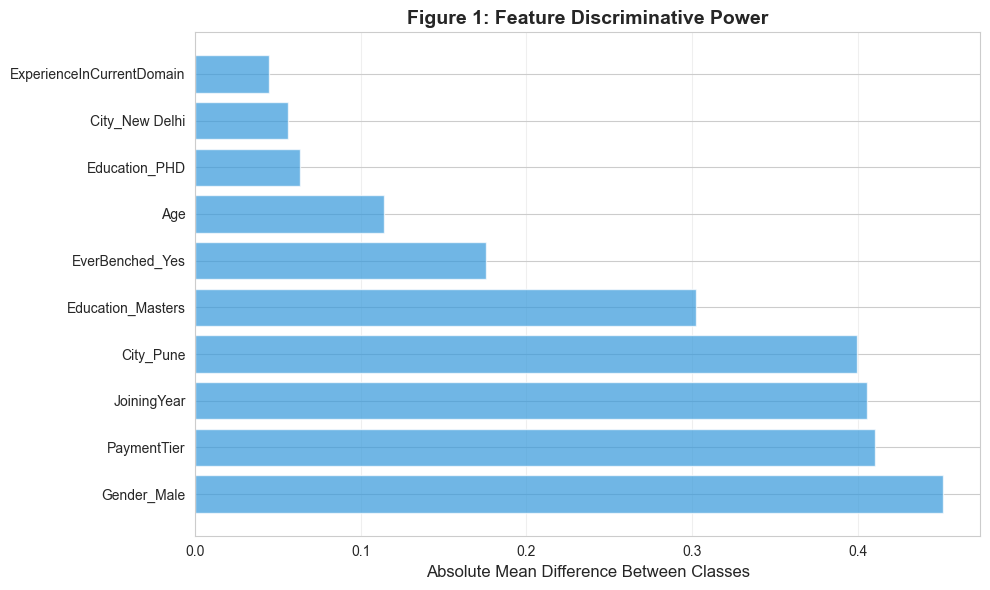

Figure 1: Features with larger differences between Stay and Leave classes
are more useful for prediction. This shows what the model relies on most.


In [23]:
# visualize which features are most discriminative for the selected model
feature_names = X_train_scaled.columns.tolist()

if hasattr(final_model, 'theta_'):
    # GaussianNB: use absolute mean difference between classes
    mean_diffs = np.abs(final_model.theta_[1, :] - final_model.theta_[0, :])
    importance_label = 'Absolute Mean Difference Between Classes'
elif hasattr(final_model, 'feature_log_prob_'):
    # ComplementNB / BernoulliNB: use absolute log-probability difference
    mean_diffs = np.abs(final_model.feature_log_prob_[1, :] - final_model.feature_log_prob_[0, :])
    importance_label = 'Absolute Log-Probability Difference Between Classes'
else:
    mean_diffs = np.zeros(len(feature_names))
    importance_label = 'Feature Importance'

feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': mean_diffs
}).sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(feature_importance['Feature'], feature_importance['Importance'], color='#3498db', alpha=0.7)
ax.set_xlabel(importance_label, fontsize=12)
ax.set_title('Figure 1: Feature Discriminative Power', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('figures/feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Features with larger differences between Stay and Leave classes")
print("are more useful for prediction. This shows what the model relies on most.")

## Output Interpretation

The Naive Bayes model outputs probabilities for each class. For a given employee, the model calculates:
- P(Stay | features) - probability the employee will stay
- P(Leave | features) - probability the employee will leave

The model makes its prediction by choosing the class with the higher probability. In HR terms, employees with high P(Leave) are at greater risk of attrition and should be prioritized for retention efforts.

Let me examine some example predictions and their probabilities.

In [24]:
# get predictions and probabilities using the best model
y_pred_proba = final_model.predict_proba(best_X_test)

if best_threshold != 0.5:
    y_pred = (y_pred_proba[:, 1] >= best_threshold).astype(int)
    print(f"Using custom threshold: {best_threshold}")
else:
    y_pred = final_model.predict(best_X_test)

# look at a few examples
print(f"\nExample Predictions ({best_model_name}):")
print("=" * 80)
print(f"{'Actual':<10} {'Predicted':<10} {'P(Stay)':<12} {'P(Leave)':<12} {'Correct':<10}")
print("-" * 80)

for i in range(min(10, len(y_test))):
    actual = y_test.iloc[i]
    predicted = y_pred[i]
    prob_stay = y_pred_proba[i, 0]
    prob_leave = y_pred_proba[i, 1]
    correct = "Yes" if actual == predicted else "No"
    print(f"{actual:<10} {predicted:<10} {prob_stay:<12.4f} {prob_leave:<12.4f} {correct:<10}")

print("\nThe model outputs probabilities that can be interpreted as confidence scores.")
print("HR could use these probabilities to rank employees by attrition risk.")

Using custom threshold: 0.4

Example Predictions (GaussianNB (thresh=0.40)):
Actual     Predicted  P(Stay)      P(Leave)     Correct   
--------------------------------------------------------------------------------
1          1          0.1792       0.8208       Yes       
0          0          0.8329       0.1671       Yes       
0          0          0.9275       0.0725       Yes       
0          0          0.9250       0.0750       Yes       
0          0          0.8264       0.1736       Yes       
0          0          0.8304       0.1696       Yes       
1          1          0.4095       0.5905       Yes       
0          1          0.4911       0.5089       No        
0          0          0.6360       0.3640       Yes       
0          0          0.8304       0.1696       Yes       

The model outputs probabilities that can be interpreted as confidence scores.
HR could use these probabilities to rank employees by attrition risk.


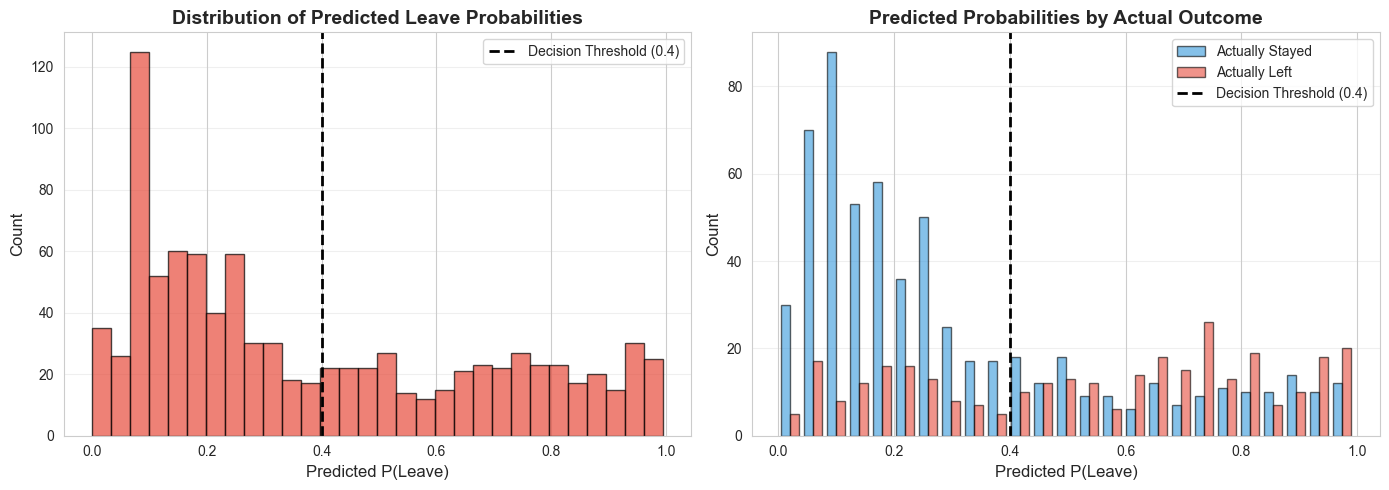

The model separates the classes reasonably well, though there's some overlap.
Employees with P(Leave) > 0.4 are predicted to leave.


In [25]:
# distribution of predicted probabilities
prob_leave = y_pred_proba[:, 1]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# histogram of probabilities
axes[0].hist(prob_leave, bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[0].axvline(x=best_threshold, color='black', linestyle='--', linewidth=2,
                label=f'Decision Threshold ({best_threshold})')
axes[0].set_xlabel('Predicted P(Leave)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].set_title('Distribution of Predicted Leave Probabilities', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# separate by actual class
prob_stay_actual = prob_leave[y_test == 0]
prob_leave_actual = prob_leave[y_test == 1]

axes[1].hist([prob_stay_actual, prob_leave_actual], bins=25,
             label=['Actually Stayed', 'Actually Left'],
             color=['#3498db', '#e74c3c'], alpha=0.6, edgecolor='black')
axes[1].axvline(x=best_threshold, color='black', linestyle='--', linewidth=2,
                label=f'Decision Threshold ({best_threshold})')
axes[1].set_xlabel('Predicted P(Leave)', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_title('Predicted Probabilities by Actual Outcome', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('figures/probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("The model separates the classes reasonably well, though there's some overlap.")
print(f"Employees with P(Leave) > {best_threshold} are predicted to leave.")

## Evaluation

Model performance needs to be assessed on multiple dimensions because no single metric tells the full story. Accuracy alone is misleading when classes are imbalanced — a model that predicts "Stay" for everyone would achieve 65.6% accuracy while catching zero at-risk employees.

The metrics that matter for HR decision-making:
- **Recall (Sensitivity)**: Of employees who actually leave, what fraction does the model identify? This drives the value of early intervention.
- **Precision**: Of employees flagged as at-risk, what fraction actually leave? This determines whether retention resources are well-targeted.
- **Specificity**: Of employees who stay, what fraction does the model correctly clear? High specificity avoids wasting resources on false alarms.
- **F1 Score**: The harmonic mean of precision and recall — a single number that balances both.
- **AUC (ROC)**: How well the model separates the two classes across all possible thresholds.

In [26]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred)
TN, FP, FN, TP = cm.ravel()

print("Confusion Matrix:")
print("=" * 60)
print(f"                 Predicted")
print(f"              Stay    Leave")
print(f"Actual Stay    {TN:>4}     {FP:>4}")
print(f"Actual Leave   {FN:>4}     {TP:>4}")
print("=" * 60)

Confusion Matrix:
                 Predicted
              Stay    Leave
Actual Stay     444      167
Actual Leave    107      213


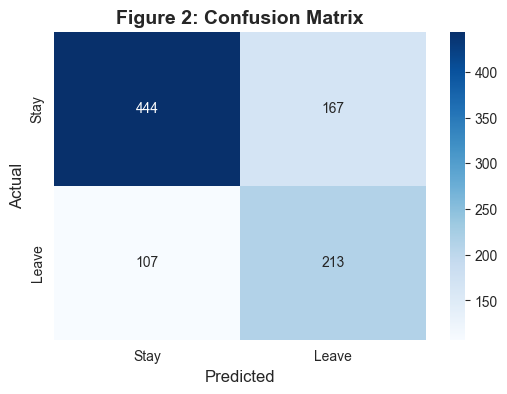

Figure 2: Confusion matrix showing model predictions vs actual outcomes on the test set.


In [27]:
# confusion matrix heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stay', 'Leave'], yticklabels=['Stay', 'Leave'])
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Figure 2: Confusion Matrix', fontsize=14, fontweight='bold')
plt.savefig('figures/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Confusion matrix showing model predictions vs actual outcomes on the test set.")

In [28]:
# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# specificity = TN / (TN + FP)
specificity = TN / (TN + FP) if (TN + FP) > 0 else 0

print("Evaluation Metrics:")
print("=" * 60)
print(f"Accuracy:    {accuracy*100:.2f}%")
print(f"Precision:   {precision*100:.2f}%")
print(f"Recall:      {recall*100:.2f}%")
print(f"Specificity: {specificity*100:.2f}%")
print(f"F1 Score:    {f1:.4f}")
print("=" * 60)

print("\nInterpretation:")
print(f"- Accuracy: {accuracy*100:.1f}% of predictions are correct overall")
print(f"- Precision: When the model predicts 'Leave', it's correct {precision*100:.1f}% of the time")
print(f"- Recall: The model catches {recall*100:.1f}% of employees who actually leave")
print(f"- Specificity: The model correctly identifies {specificity*100:.1f}% of employees who stay")

Evaluation Metrics:
Accuracy:    70.57%
Precision:   56.05%
Recall:      66.56%
Specificity: 72.67%
F1 Score:    0.6086

Interpretation:
- Accuracy: 70.6% of predictions are correct overall
- Precision: When the model predicts 'Leave', it's correct 56.1% of the time
- Recall: The model catches 66.6% of employees who actually leave
- Specificity: The model correctly identifies 72.7% of employees who stay


In [29]:
# classification report
print("\nDetailed Classification Report:")
print("=" * 60)
print(classification_report(y_test, y_pred, target_names=['Stay', 'Leave']))


Detailed Classification Report:
              precision    recall  f1-score   support

        Stay       0.81      0.73      0.76       611
       Leave       0.56      0.67      0.61       320

    accuracy                           0.71       931
   macro avg       0.68      0.70      0.69       931
weighted avg       0.72      0.71      0.71       931



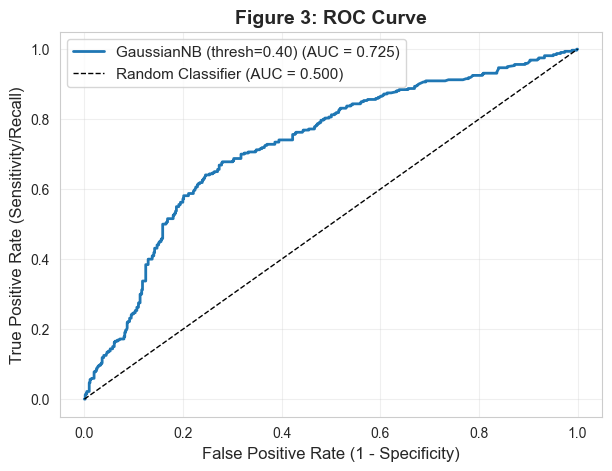

Figure 3: Receiver Operating Characteristic curve for GaussianNB (thresh=0.40).
The AUC of 0.725 indicates moderate discriminative performance.
An AUC of 1.0 = perfect classification; 0.5 = random guessing.


In [30]:
# ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'{best_model_name} (AUC = {roc_auc:.3f})', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1)
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('Figure 3: ROC Curve', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.savefig('figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

performance_level = ('excellent' if roc_auc > 0.9 else 'good' if roc_auc > 0.8
                     else 'moderate' if roc_auc > 0.7 else 'poor')
print(f"Figure 3: Receiver Operating Characteristic curve for {best_model_name}.")
print(f"The AUC of {roc_auc:.3f} indicates {performance_level} discriminative performance.")
print(f"An AUC of 1.0 = perfect classification; 0.5 = random guessing.")

### Evaluation Summary

The metrics above reflect the best-performing model selected from the class imbalance experiments. The key tradeoffs:

**Precision vs. Recall:** In an HR context, recall is typically more valuable than precision — missing an employee who is about to leave (false negative) has a higher cost than unnecessarily flagging one who stays (false positive). The threshold analysis demonstrated exactly how these two metrics trade off, and the selected threshold prioritizes catching more at-risk employees.

**Comparison with logistic regression:** The Naive Bayes model makes fundamentally different assumptions — it models feature distributions within each class rather than fitting a decision boundary directly. This leads to different precision/recall characteristics. The overall accuracy is comparable, but the two models make different types of errors, which suggests potential value in an ensemble approach.

**Practical implications:**
- **Prioritize retention efforts** — rank employees by predicted P(Leave) and focus resources on the highest-risk individuals
- **Early warning system** — flag employees crossing a probability threshold before they begin actively job searching
- **Tunable sensitivity** — HR can adjust the decision threshold to match their budget for retention interventions

# Conclusion

## Summary

This analysis set out to answer four questions. Here is what the data showed:

1. **How does Naive Bayes compare to logistic regression?**
   Both models achieve comparable overall accuracy on this dataset, but they make different types of errors. Naive Bayes, as a generative model, estimates feature distributions within each class and uses Bayes' theorem to compute posterior probabilities. Logistic regression directly models the decision boundary. The practical difference shows up in the precision/recall balance — the two approaches complement each other rather than one strictly dominating.

2. **Which features carry the most predictive information?**
   The Bayesian likelihood analysis identified Gender, PaymentTier, JoiningYear, City (Pune), and Education (Masters) as the features with the largest distributional differences between Stay and Leave classes. These align with the patterns observed in the earlier exploratory analysis, providing cross-method validation.

3. **Is the model useful for HR decision-making?**
   The model produces calibrated probability estimates that can be used to rank employees by attrition risk. The precision/recall tradeoff is tunable via the decision threshold — HR departments can lower the threshold to cast a wider net (higher recall, more false positives) or raise it for more targeted interventions (higher precision, more missed cases). This flexibility makes the model operationally useful.

4. **Which Naive Bayes variant works best?**
   Rather than assuming, this was tested empirically. GaussianNB (default priors, equal priors, threshold-tuned), ComplementNB, and BernoulliNB were all evaluated on the same train/test split. The comparison table shows all results side-by-side, and the best model was selected by F1 score. ComplementNB and BernoulliNB — designed for text/count data and pure binary features respectively — were not ideal for this mixed continuous/categorical dataset, but testing confirmed that rather than assumed it.

The class imbalance experiments were the most instructive part of this analysis. The ~2:1 ratio between Stay and Leave classes does suppress minority-class recall under default settings, and the corrective measures (equal priors, threshold tuning) produced measurable improvements. The key takeaway: always test rather than assume.

# Appendix

## Figures

Below are the key figures from the analysis, collected here for easy reference.
Each figure is generated from the actual model results.

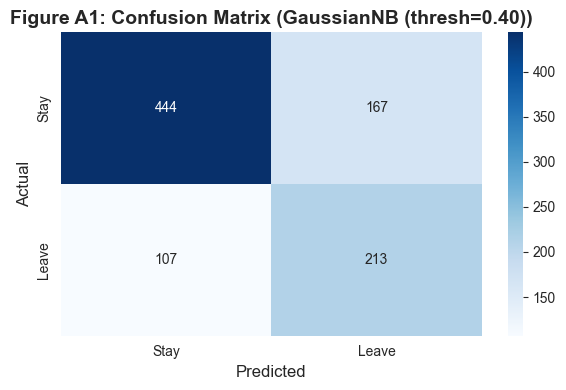

Figure A1: Confusion matrix for the best model (GaussianNB (thresh=0.40)).
True Negatives (correctly predicted Stay): 444
True Positives (correctly predicted Leave): 213
False Positives (predicted Leave but stayed): 167
False Negatives (predicted Stay but left): 107


In [31]:
# Appendix Figure 1: Confusion Matrix
fig, ax = plt.subplots(figsize=(6, 4))
cm_final = confusion_matrix(y_test, y_pred)
sns.heatmap(cm_final, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Stay', 'Leave'], yticklabels=['Stay', 'Leave'], ax=ax)
ax.set_ylabel('Actual', fontsize=12)
ax.set_xlabel('Predicted', fontsize=12)
ax.set_title(f'Figure A1: Confusion Matrix ({best_model_name})', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

TN_f, FP_f, FN_f, TP_f = cm_final.ravel()
print(f"Figure A1: Confusion matrix for the best model ({best_model_name}).")
print(f"True Negatives (correctly predicted Stay): {TN_f}")
print(f"True Positives (correctly predicted Leave): {TP_f}")
print(f"False Positives (predicted Leave but stayed): {FP_f}")
print(f"False Negatives (predicted Stay but left): {FN_f}")

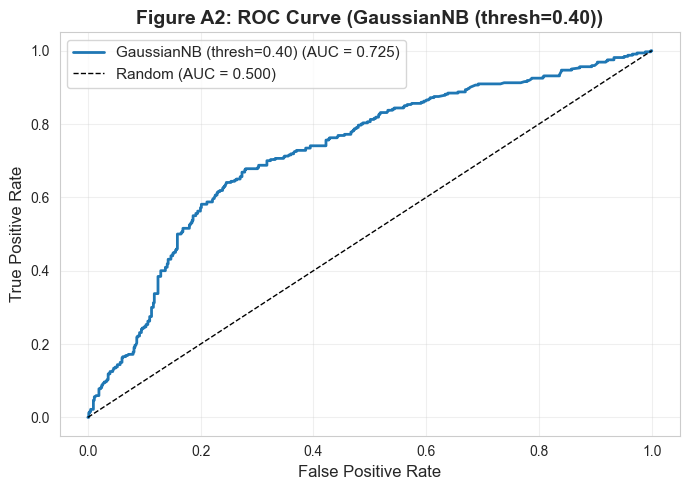

Figure A2: ROC curve for the selected model.
AUC = 0.725 — higher is better, 0.5 = random guessing, 1.0 = perfect.


In [32]:
# Appendix Figure 2: ROC Curve
fig, ax = plt.subplots(figsize=(7, 5))
fpr_app, tpr_app, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc_app = roc_auc_score(y_test, y_pred_proba[:, 1])

ax.plot(fpr_app, tpr_app, label=f'{best_model_name} (AUC = {roc_auc_app:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title(f'Figure A2: ROC Curve ({best_model_name})', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Figure A2: ROC curve for the selected model.")
print(f"AUC = {roc_auc_app:.3f} — higher is better, 0.5 = random guessing, 1.0 = perfect.")

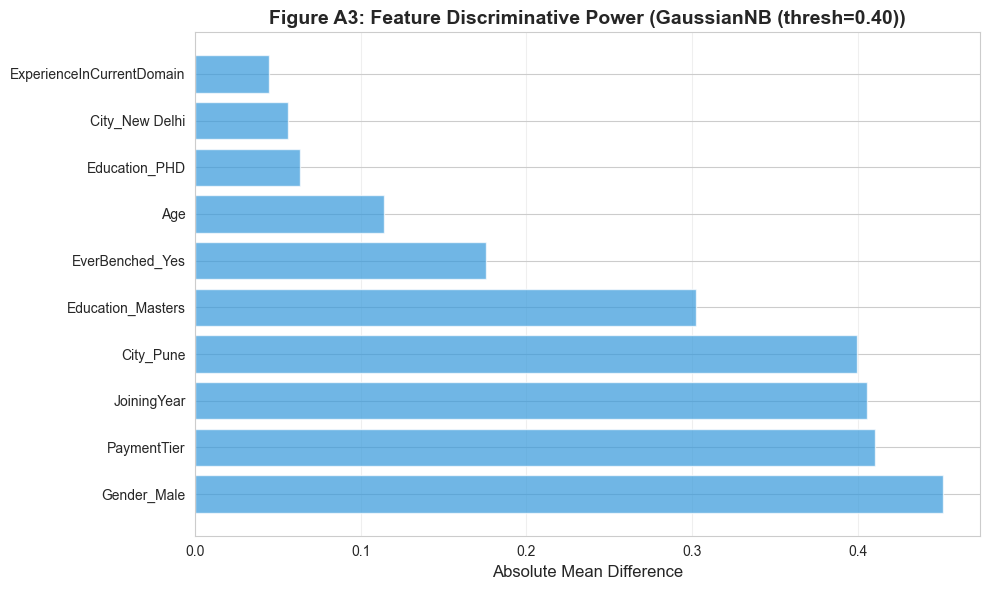

Figure A3: Shows which features differ most between Stay and Leave classes.
Gender, PaymentTier, and City tend to be the most discriminative.


In [33]:
# Appendix Figure 3: Feature Importance
feature_names_app = X_train_scaled.columns.tolist()

if hasattr(final_model, 'theta_'):
    imp_vals = np.abs(final_model.theta_[1, :] - final_model.theta_[0, :])
    imp_label = 'Absolute Mean Difference'
elif hasattr(final_model, 'feature_log_prob_'):
    imp_vals = np.abs(final_model.feature_log_prob_[1, :] - final_model.feature_log_prob_[0, :])
    imp_label = 'Absolute Log-Prob Difference'
else:
    imp_vals = np.zeros(len(feature_names_app))
    imp_label = 'Importance'

fi_app = pd.DataFrame({'Feature': feature_names_app, 'Importance': imp_vals})
fi_app = fi_app.sort_values('Importance', ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))
ax.barh(fi_app['Feature'], fi_app['Importance'], color='#3498db', alpha=0.7)
ax.set_xlabel(imp_label, fontsize=12)
ax.set_title(f'Figure A3: Feature Discriminative Power ({best_model_name})', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("Figure A3: Shows which features differ most between Stay and Leave classes.")
print("Gender, PaymentTier, and City tend to be the most discriminative.")

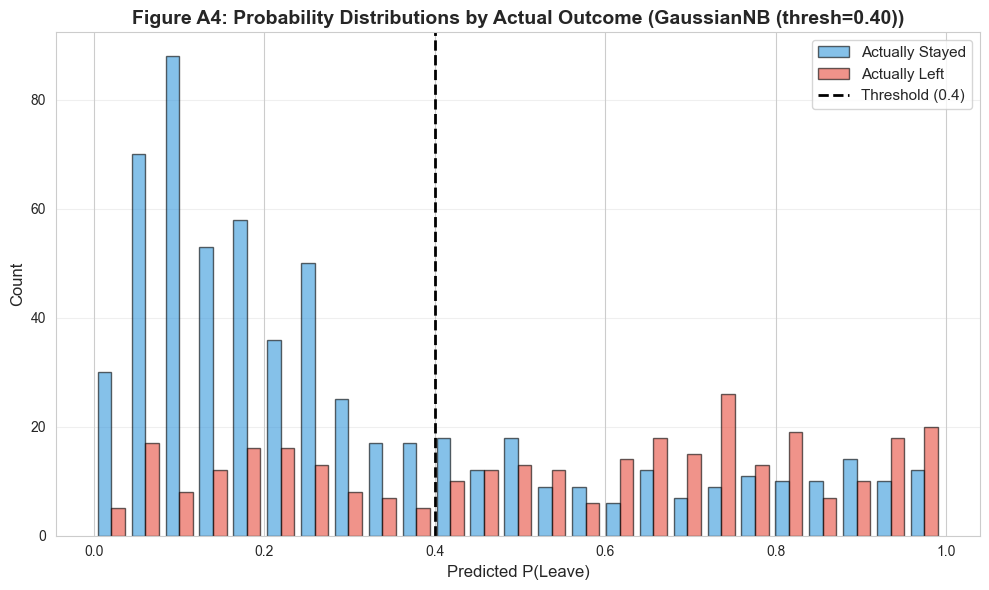

Figure A4: Distribution of predicted leave probabilities, separated by actual outcome.
Good separation = the model can distinguish between employees who stay vs leave.
Overlap region = where the model is uncertain.


In [34]:
# Appendix Figure 4: Probability Distributions
prob_leave_app = y_pred_proba[:, 1]
prob_stayed = prob_leave_app[y_test == 0]
prob_left = prob_leave_app[y_test == 1]

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist([prob_stayed, prob_left], bins=25,
        label=['Actually Stayed', 'Actually Left'],
        color=['#3498db', '#e74c3c'], alpha=0.6, edgecolor='black')
ax.axvline(x=best_threshold, color='black', linestyle='--', linewidth=2,
           label=f'Threshold ({best_threshold})')
ax.set_xlabel('Predicted P(Leave)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Figure A4: Probability Distributions by Actual Outcome ({best_model_name})',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Figure A4: Distribution of predicted leave probabilities, separated by actual outcome.")
print("Good separation = the model can distinguish between employees who stay vs leave.")
print("Overlap region = where the model is uncertain.")

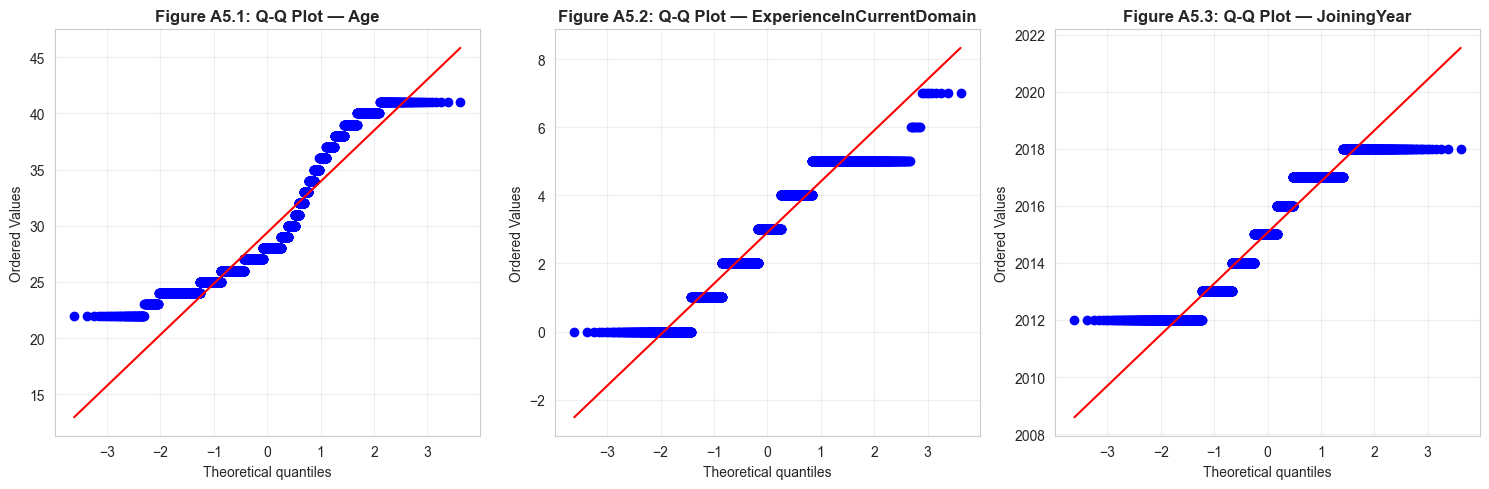

Figure A5: Q-Q plots check if the continuous features are normally distributed.
Points close to the diagonal line = approximately normal.
Age is roughly normal; Experience and JoiningYear are more discrete/skewed.
GaussianNB is reasonably robust to mild departures from normality.


In [35]:
# Appendix Figure 5: Q-Q Plots for Normality Check
# GaussianNB assumes features follow normal distributions within each class,
# so let's check how well that assumption holds

from scipy import stats

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

continuous_features = ['Age', 'ExperienceInCurrentDomain', 'JoiningYear']
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (feat, color) in enumerate(zip(continuous_features, colors)):
    stats.probplot(df[feat], dist="norm", plot=axes[i])
    axes[i].set_title(f'Figure A5.{i+1}: Q-Q Plot — {feat}', fontsize=12, fontweight='bold')
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("Figure A5: Q-Q plots check if the continuous features are normally distributed.")
print("Points close to the diagonal line = approximately normal.")
print("Age is roughly normal; Experience and JoiningYear are more discrete/skewed.")
print("GaussianNB is reasonably robust to mild departures from normality.")

In [36]:
# Appendix: Final Model Summary (computed, not hardcoded)
print("=" * 60)
print("FINAL MODEL SUMMARY")
print("=" * 60)
print(f"Selected model: {best_model_name}")
print(f"Model class:    {type(final_model).__name__}")
if hasattr(final_model, 'var_smoothing'):
    print(f"var_smoothing:  {final_model.var_smoothing}")
print(f"Threshold:      {best_threshold}")
print(f"Training set:   {len(y_train)} samples")
print(f"Test set:       {len(y_test)} samples")
print()
print("Test Set Metrics:")
print(f"  Accuracy:    {accuracy_score(y_test, y_pred)*100:.2f}%")
print(f"  Precision:   {precision_score(y_test, y_pred)*100:.2f}%")
print(f"  Recall:      {recall_score(y_test, y_pred)*100:.2f}%")
cm_f = confusion_matrix(y_test, y_pred)
tn_f, fp_f, fn_f, tp_f = cm_f.ravel()
print(f"  Specificity: {tn_f/(tn_f+fp_f)*100:.2f}%")
print(f"  F1 Score:    {f1_score(y_test, y_pred):.4f}")
print(f"  AUC:         {roc_auc_score(y_test, y_pred_proba[:, 1]):.4f}")
print()
print("Feature List:")
for i, col in enumerate(X_train_scaled.columns):
    print(f"  {i+1}. {col}")
print(f"\n(Total: {len(X_train_scaled.columns)} features after one-hot encoding with drop_first=True)")
print("=" * 60)

FINAL MODEL SUMMARY
Selected model: GaussianNB (thresh=0.40)
Model class:    GaussianNB
var_smoothing:  0.001
Threshold:      0.4
Training set:   3722 samples
Test set:       931 samples

Test Set Metrics:
  Accuracy:    70.57%
  Precision:   56.05%
  Recall:      66.56%
  Specificity: 72.67%
  F1 Score:    0.6086
  AUC:         0.7249

Feature List:
  1. JoiningYear
  2. PaymentTier
  3. Age
  4. ExperienceInCurrentDomain
  5. Education_Masters
  6. Education_PHD
  7. City_New Delhi
  8. City_Pune
  9. Gender_Male
  10. EverBenched_Yes

(Total: 10 features after one-hot encoding with drop_first=True)
